In [171]:
!pip install statsmodels



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Fourier analysis
from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

#Regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

#metrics and CV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

display(train_data.head(5))
display(test_data.head(5))

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896


## Exploratieve Data Analyse

In [174]:
display(train_data.dtypes)
display(train_data.describe())

date_hour      object
holiday         int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


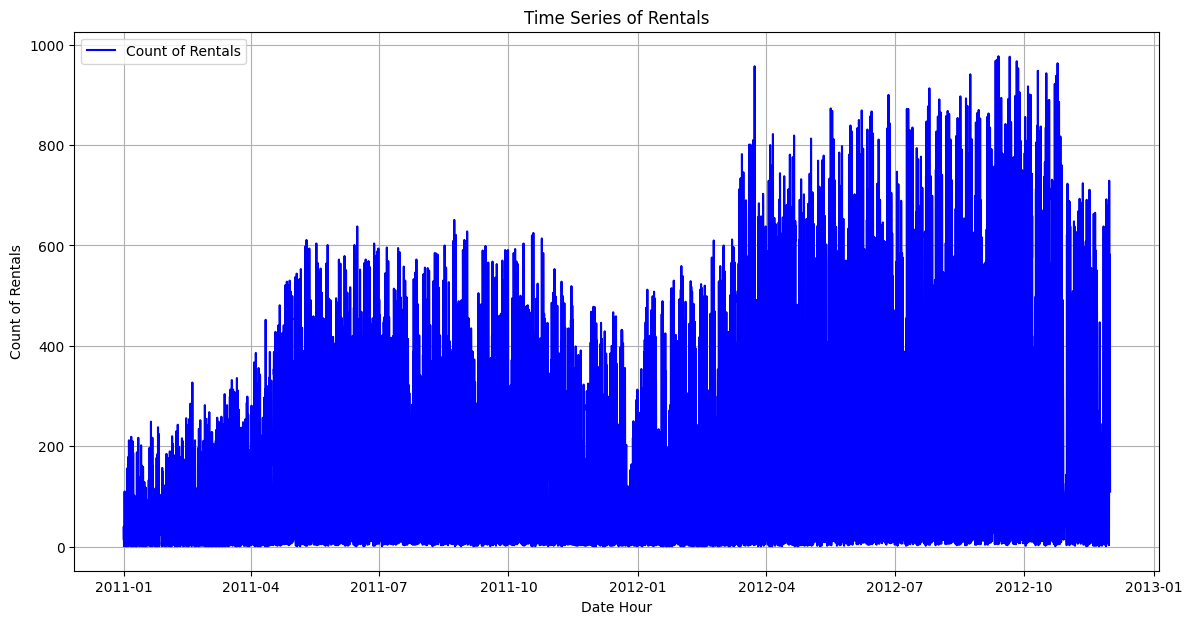

In [175]:
train_data['date_hour'] = pd.to_datetime(train_data['date_hour'])

train_data.set_index('date_hour', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['cnt'], color='blue', label='Count of Rentals')
plt.title('Time Series of Rentals')
plt.xlabel('Date Hour')
plt.ylabel('Count of Rentals')
plt.legend()
plt.grid()
plt.show()


C:\Users\tijnw\AppData\Local\Temp\ipykernel_4560\863123823.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, x='weathersit', y='cnt', palette='Set2')


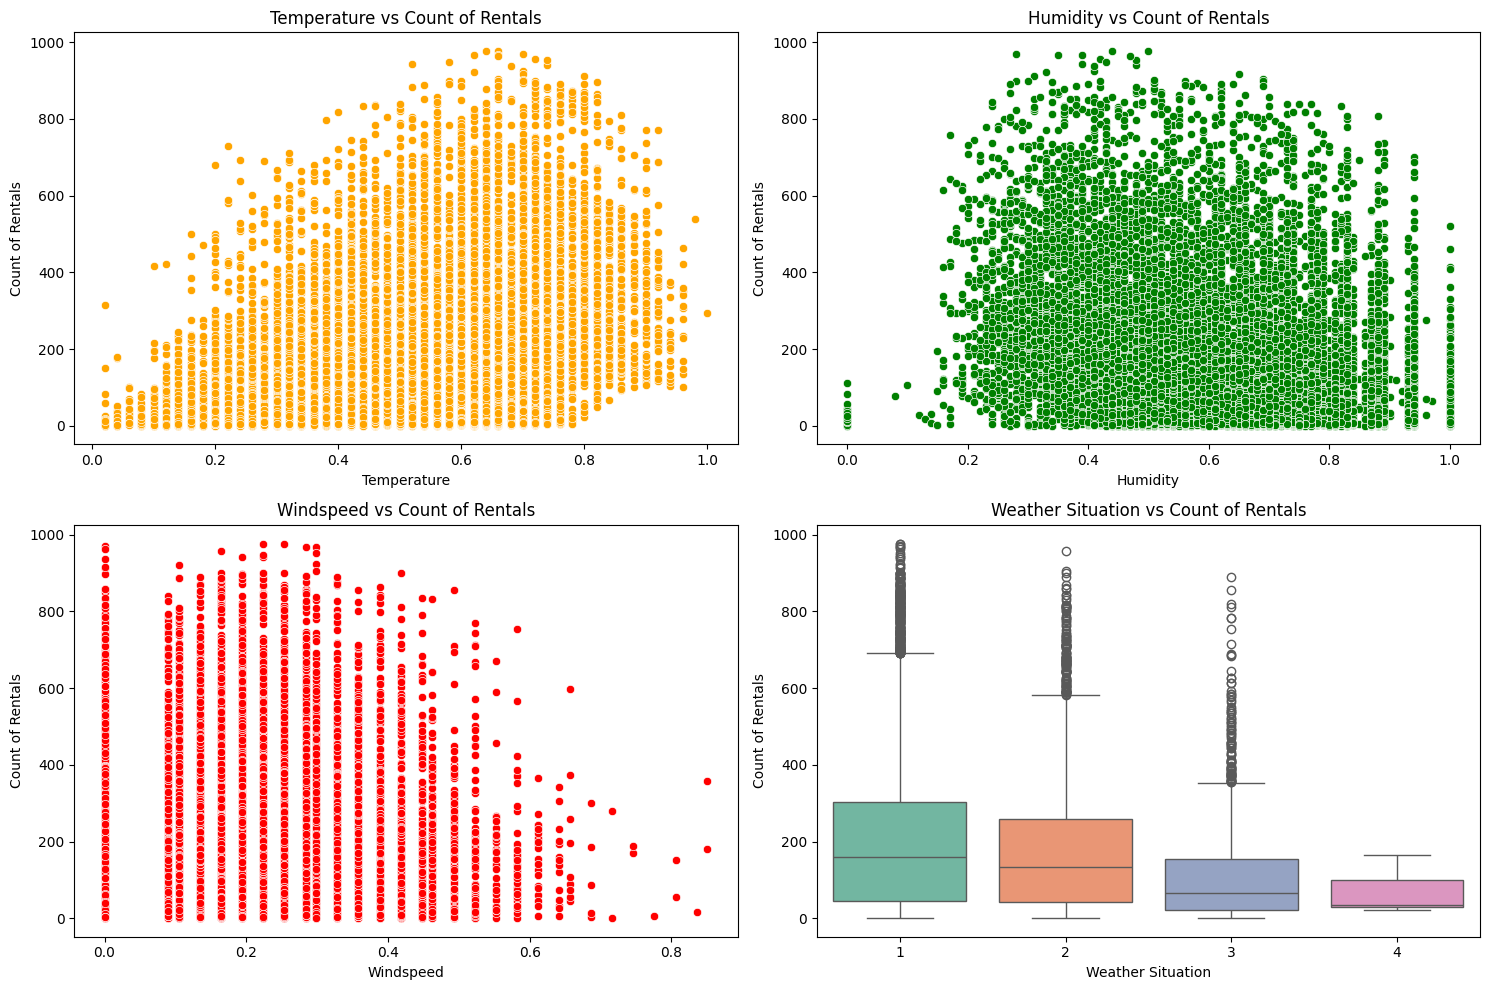

In [176]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(data=train_data, x='temp', y='cnt', color='orange')
plt.title('Temperature vs Count of Rentals')
plt.xlabel('Temperature')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 2)
sns.scatterplot(data=train_data, x='hum', y='cnt', color='green')
plt.title('Humidity vs Count of Rentals')
plt.xlabel('Humidity')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 3)
sns.scatterplot(data=train_data, x='windspeed', y='cnt', color='red')
plt.title('Windspeed vs Count of Rentals')
plt.xlabel('Windspeed')
plt.ylabel('Count of Rentals')

plt.subplot(2, 2, 4)
sns.boxplot(data=train_data, x='weathersit', y='cnt', palette='Set2')
plt.title('Weather Situation vs Count of Rentals')
plt.xlabel('Weather Situation')
plt.ylabel('Count of Rentals')

plt.tight_layout()
plt.show()

1. De tijdrijgrafiek laat zien dat verhuur duidelijke seizoenspatronen heeft, met pieken tijdens bepaalde periodes van het jaar.  
2. Er is een positieve correlatie tussen temperatuur en het aantal verhuur, wat suggereert dat hogere temperaturen leiden tot meer verhuur.  
3. Luchtvochtigheid lijkt een negatief effect te hebben op verhuur; naarmate de luchtvochtigheid toeneemt, neemt het aantal verhuurd af.  
4. Windsnelheid toont een zwakke negatieve correlatie met verhuur, wat erop wijst dat hogere windsnelheden gebruikers kunnen ontmoedigen om te huren.  
5. De boxplot voor weersituatie laat zien dat bepaalde weersomstandigheden (zoals helder of licht bewolkt) geassocieerd zijn met hogere aantallen verhuur in vergelijking met andere omstandigheden (zoals regen of sneeuw).  


### Data cleaning

In [177]:
missing_values = train_data.isnull().sum()
duplicates = train_data.duplicated().sum()

print('Missing Values per Column:')
print(missing_values)
print(f'Total Duplicates: {duplicates}')

Missing Values per Column:
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64
Total Duplicates: 106


Er zijn geen missende waarde, wel zijn er 106 dubbele rijen. Door deze te verwijderen maken we de dataset uniek en consistent.

In [178]:
train_data_cleaned = train_data.drop_duplicates()
cleaned_shape = train_data_cleaned.shape

print(f'Original shape: {train_data.shape}')
print(f'Cleaned shape: {cleaned_shape}')

Original shape: (16637, 7)
Cleaned shape: (16531, 7)


### Relevantie bepalen

<Axes: >

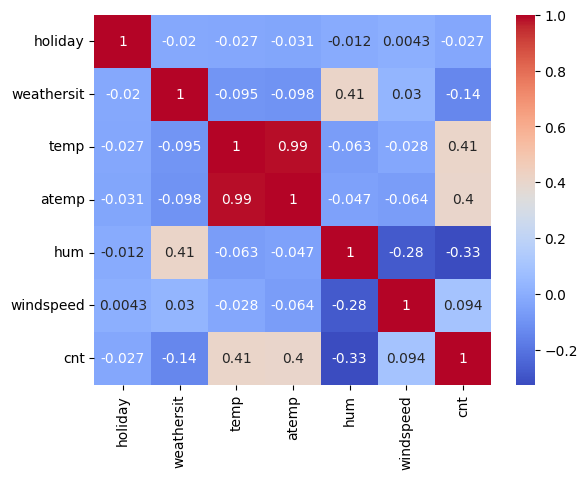

In [179]:
correlation_matrix = train_data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

- We berekenen de correlatie om te zien welke gegevens belangrijk kunnen zijn.
- We kiezen de kolommen die nuttig zijn.
- We maken een kleinere, overzichtelijke dataset waarmee je verder kunt werken.

## Time series feature engineering

In [180]:
train_data_final = train_data_cleaned.copy()

In [181]:
train_data_final['year'] = train_data_final.index.year
train_data_final['month'] = train_data_final.index.month
train_data_final['day'] = train_data_final.index.day
train_data_final['day_of_week'] = train_data_final.index.dayofweek
train_data_final['quarter'] = train_data_final.index.quarter

train_data_final['sin_month'] = np.sin(2 * np.pi * train_data_final['month'] / 12)
train_data_final['cos_month'] = np.cos(2 * np.pi * train_data_final['month'] / 12)

train_data_final.head()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,day_of_week,quarter,sin_month,cos_month
date_hour,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,1,5,1,0.5,0.866025
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,1,5,1,0.5,0.866025
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,1,5,1,0.5,0.866025
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,1,5,1,0.5,0.866025
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,1,5,1,0.5,0.866025


We voegen extra kolommen toe aan onze dataset om meer informatie uit de datum-index te halen. Deze extra gegevens kunnen ons helpen om patronen en trends beter te begrijpen en ons model te verbeteren.

We halen het jaar, maand, dag, dag van de week en het kwartaal uit de datum-index:
- Zo kunnen we analyseren of er bepaalde trends zijn die te maken hebben met tijd.

Seizoenspatronen toevoegen met sinus en cosinus:
- We gebruiken de maand en zetten deze om in sinus- en cosinuswaarden. Dit is handig om seizoensgebonden patronen te modelleren, zoals veranderingen door de tijd heen.
- Door sinus en cosinus te gebruiken, geven we onze dataset een cyclische structuur: januari (maand 1) en december (maand 12) liggen hierdoor dicht bij elkaar, wat logischer is voor maandelijkse trends.

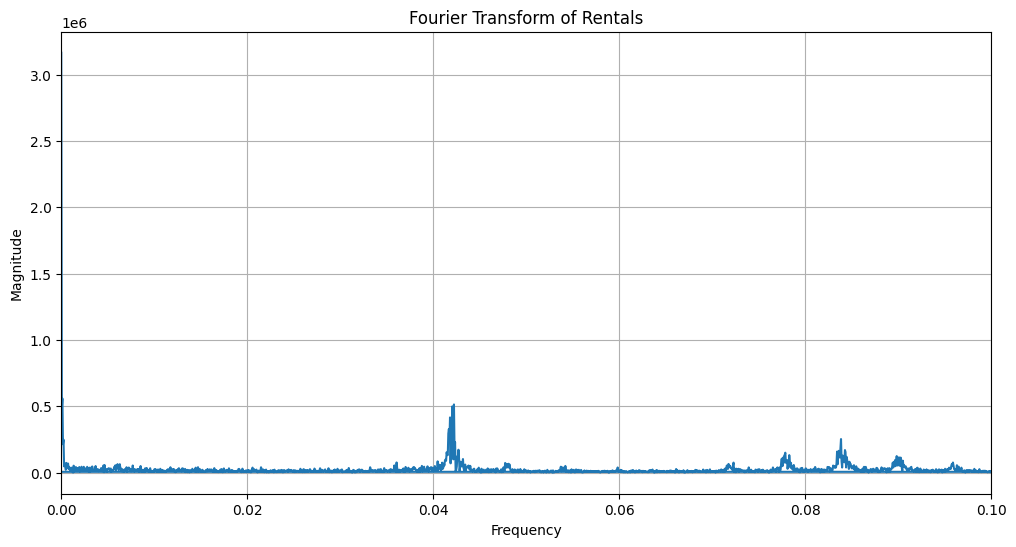

In [182]:
cnt_values = train_data_final['cnt'].values

fourier_transform = fft(cnt_values)

n = len(cnt_values)
frequencies = np.fft.fftfreq(n)

plt.figure(figsize=(12, 6))
plt.plot(frequencies, np.abs(fourier_transform))
plt.title('Fourier Transform of Rentals')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 0.1)
plt.grid()
plt.show()

Piek rond 0.04:
- Dit suggereert een belangrijke cyclische trend. Dit kan bijvoorbeeld een wekelijkse of maandelijkse piek zijn in het verhuur.

Andere pieken:
- Er zijn kleinere pieken op andere frequenties. Dit wijst op minder sterke terugkerende patronen.

Lage frequenties (links):
- Hier zitten langzame trends, zoals seizoensgebonden invloeden (bijvoorbeeld zomer- of wintereffecten).

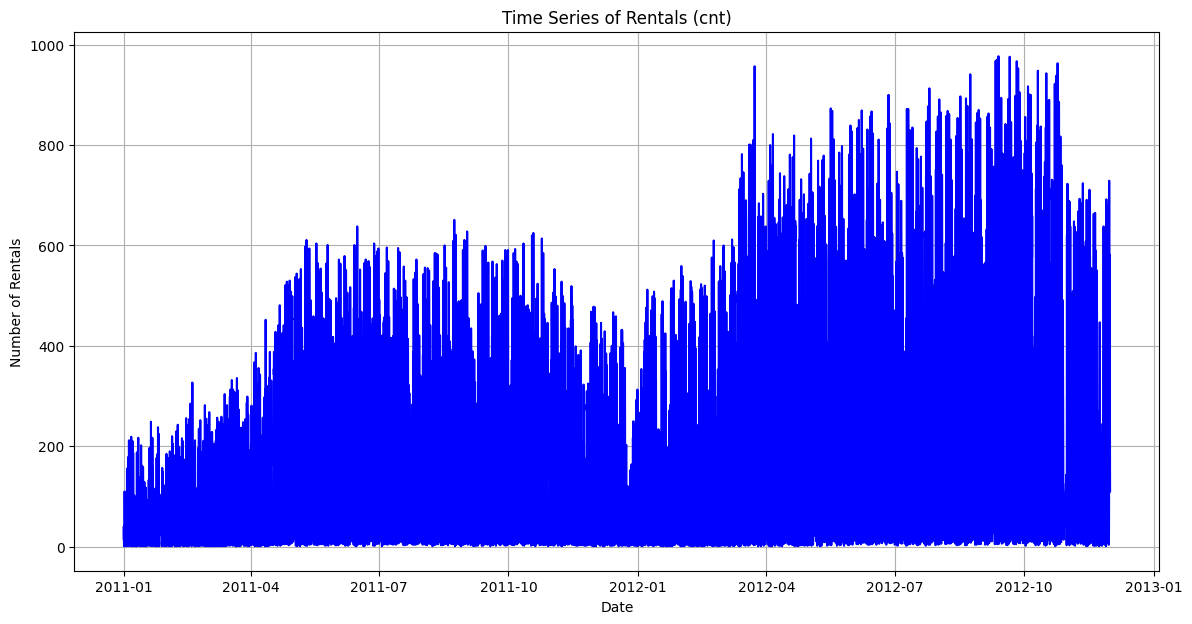

In [183]:
plt.figure(figsize=(14, 7))
plt.plot(train_data_final.index, train_data_final['cnt'], color='blue')
plt.title('Time Series of Rentals (cnt)')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.grid()
plt.show()

### Seizoensgebonden trends:
- In de lente en zomer (rond het midden van 2011 en 2012) zie je een duidelijke toename in het aantal verhuur. Dit kan worden toegeschreven aan het betere weer in die perioden.
- In de herfst en winter (eind 2011 en 2012) zie je een daling, waarschijnlijk door kouder weer en minder gunstige weersomstandigheden voor verhuren.

### Langzame groei in 2011:
- Het aantal verhuur stijgt geleidelijk in het eerste jaar (2011). Dit kan te maken hebben met een groeiende populariteit of uitbreiding van de verhuurdienst.

### Schommelingen:
- Je ziet dagelijkse of wekelijkse pieken en dalen. Mogelijk zijn dit weekdagen versus weekends, waarbij verhuur in het weekend hoger is.

### Sterkere verhuur in 2012:
- In 2012 lijkt het gemiddeld aantal verhuur per dag hoger te liggen dan in 2011.

### Seizoenspiek in de zomer:
- De hoogste waarden (bijvoorbeeld in de zomer van 2012) wijzen op maximale drukte in die periode.


<Figure size 1200x600 with 0 Axes>

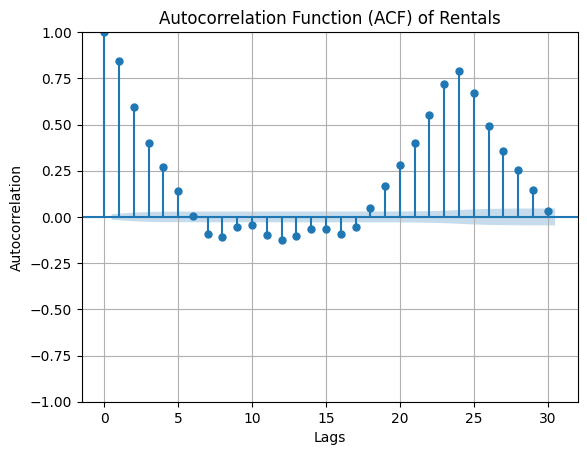

In [184]:
plt.figure(figsize=(12, 6))
plot_acf(train_data_final['cnt'], lags=30)
plt.title('Autocorrelation Function (ACF) of Rentals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

De ACF meet hoe sterk de waarde van het aantal verhuur op een specifieke dag (de "lag 0") correleert met de waarden van eerdere dagen (bijvoorbeeld "lag 1", "lag 2", enz.). Dit helpt ons patronen in de tijdreeksen te begrijpen.

- Er is een sterk dagelijks patroon (opeenvolgende dagen zijn gerelateerd).
- Er lijkt een herhalend patroon te zijn over langere periodes (bijvoorbeeld weken of maanden).

In [1]:
train_data_final['is_weekend'] = train_data_final['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
train_data_final['season'] = train_data_final['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
train_data_final['is_spring'] = train_data_final['season'].apply(lambda x: 1 if x == 'spring' else 0)
train_data_final['is_summer'] = train_data_final['season'].apply(lambda x: 1 if x == 'summer' else 0)
train_data_final['is_autumn'] = train_data_final['season'].apply(lambda x: 1 if x == 'autumn' else 0)
train_data_final['is_winter'] = train_data_final['season'].apply(lambda x: 1 if x == 'winter' else 0)

train_data_final['temp_atemp_diff'] = train_data_final['temp'] - train_data_final['atemp']
train_data_final['hum_windspeed_interaction'] = train_data_final['hum'] * train_data_final['windspeed']

train_data_final['sin_day_of_week'] = np.sin(2 * np.pi * train_data_final['day_of_week'] / 7)
train_data_final['cos_day_of_week'] = np.cos(2 * np.pi * train_data_final['day_of_week'] / 7)

train_data_final['is_month_end'] = train_data_final['day'] >= 25


train_data_final['temp_month_rel'] = train_data_final['temp'] / train_data_final.groupby('month')['temp'].transform('mean')
train_data_final['hum_month_rel'] = train_data_final['hum'] / train_data_final.groupby('month')['hum'].transform('mean')

train_data_final['is_heatwave'] = train_data_final['temp'] > 30
train_data_final['is_storm'] = train_data_final['windspeed'] > 40

train_data_final['windspeed_change'] = train_data_final['windspeed'] - train_data_final['windspeed'].shift(1)

train_data_final['temp_diff_from_max'] = train_data_final['temp'] - train_data_final.groupby('month')['temp'].transform('max')
train_data_final['temp_windspeed_interaction'] = train_data_final['temp'] * train_data_final['windspeed']

train_data_final['lagged_temp'] = train_data_final['temp'].shift(1)
train_data_final['lagged_hum'] = train_data_final['hum'].shift(1)
train_data_final['lagged_weathersit'] = train_data_final['weathersit'].shift(1)


display(train_data_final.head())
display(train_data_final.columns)
display(train_data_final.shape)

NameError: name 'train_data_final' is not defined

# Uitleg van Toegevoegde Kenmerken

## Tijdelijke Patronen
- **`lag_1` en `lag_2`**  
  Slaan het aantal verhuur (`cnt`) van 1 en 2 dagen eerder op:  
  - Hiermee leggen we vast hoe de verhuur op eerdere dagen invloed kan hebben op de huidige dag.

- **`rolling_mean_3` en `rolling_mean_7`**  
  Berekenen het gemiddelde aantal verhuur over 3 en 7 dagen.  

- **`rolling_std_3` en `rolling_std_7`**  
  Berekenen de schommelingen in verhuur over die periodes:  
  - Dit geeft een idee van korte- en langetermijntrends en variatie.

## Tijdsgebaseerde Kenmerken
- **`is_weekend`**  
  Geeft aan of het een zaterdag of zondag is (`1`) of niet (`0`).

- **`season`**  
  Verdeelt de maanden in winter, lente, zomer en herfst:  
  - Extra kolommen zoals `is_spring`, `is_summer`, enz., markeren of een datum in dat seizoen valt (`1`) of niet (`0`).  
  - Dit helpt bij het modelleren van seizoensinvloeden.

## Weergerelateerde Kenmerken
- **`temp_atemp_diff`**  
  Kijkt naar het verschil tussen de gemeten en gevoelstemperatuur.

- **`hum_windspeed_interaction`**  
  Combineert luchtvochtigheid en windsnelheid, wat weersomstandigheden beter samenvat.

## Cyclische Patronen
- **`sin_day_of_week` en `cos_day_of_week`**  
  Leggen vast dat dagen van de week een cyclisch patroon volgen (bijvoorbeeld maandag komt na zondag).

## Relaties met Maandgemiddelden
- **`temp_month_rel` en `hum_month_rel`**  
  Tonen hoe temperatuur en luchtvochtigheid zich verhouden tot het maandgemiddelde.

## Bijzondere Dagen
- **`is_heatwave`**  
  Markeert dagen met een temperatuur boven 30 graden.

- **`is_month_end`**  
  Geeft aan of een dag in de laatste week van de maand valt.

## Veranderingen en Interacties
- **`windspeed_change`**  
  Kijkt naar de verandering in windsnelheid vergeleken met de vorige dag.

- **`temp_diff_from_max`**  
  Vergelijkt de temperatuur met de hoogste temperatuur die maand.

- **`temp_windspeed_interaction`**  
  Combineert temperatuur en windsnelheid, wat een invloed kan hebben op verhuur.

## Lagged Kenmerken
- **`lagged_temp`, `lagged_hum`, en `lagged_weathersit`**  
  Gebruiken waarden van de vorige dag om te zien of recente trends een invloed hebben.


In [186]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint




wawaw



# Define features and target
features = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'cnt', 'year',
       'month', 'day', 'day_of_week', 'quarter', 'sin_month', 'cos_month',
       'lag_1', 'lag_2', 'rolling_mean_3', 'rolling_mean_7', 'rolling_std_3',
       'rolling_std_7', 'is_weekend', 'holiday', 'season', 'is_spring',
       'is_summer', 'is_autumn', 'is_winter', 'temp_atemp_diff',
       'hum_windspeed_interaction', 'sin_day_of_week', 'cos_day_of_week',
       'is_month_end', 'temp_month_rel', 'hum_month_rel', 'is_heatwave',
       'is_storm', 'windspeed_change', 'temp_diff_from_max',
       'temp_windspeed_interaction', 'lagged_temp', 'lagged_hum',
       'lagged_weathersit']

# Ensure data is clean and ready
X = train_data_final[features].dropna()
Y = train_data_final['cnt'][X.index]

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_cols)

# One-hot encode non-numeric columns (if any)
if 'season' in non_numeric_cols:
    X = pd.get_dummies(X, columns=['season'], drop_first=True)

# Ensure all columns are numeric
assert X.select_dtypes(include=['object', 'category']).shape[1] == 0, "Non-numeric columns remain!"

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define parameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Define scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring=scorer,
    verbose=1
)

# Fit the model
random_search.fit(X_train, Y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Predict on the test set
Y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

# Print results
print(f"Best Parameters: {best_params}")
print(f"Best Score: {random_search.best_score_}")
print(f"RMSE: {rmse}")




NameError: name 'wawaw' is not defined

## Alles in een functie zetten

In [187]:
def remove_duplicates(df):
    return df.drop_duplicates()

def generate_features(df):
    
    # Tijdgerelateerde features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter

    # Sinus- en cosinus-transformaties voor cyclic months
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # Lag features
    df['lag_1'] = df['cnt'].shift(1)
    df['lag_2'] = df['cnt'].shift(2)
    
    # Rolling statistics
    df['rolling_mean_3'] = df['cnt'].rolling(window=3).mean()
    df['rolling_mean_7'] = df['cnt'].rolling(window=7).mean()
    df['rolling_std_3'] = df['cnt'].rolling(window=3).std()
    df['rolling_std_7'] = df['cnt'].rolling(window=7).std()
    
    # Weekend and holiday indicators
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
    df['is_holiday'] = df['day_of_week'].apply(lambda x: 1 if x in [0, 1] else 0)
    
    # Seasons
    df['season'] = df['month'].apply(
        lambda x: 'winter' if x in [12, 1, 2] else 
                  'spring' if x in [3, 4, 5] else 
                  'summer' if x in [6, 7, 8] else 'autumn'
    )
    df['is_spring'] = df['season'].apply(lambda x: 1 if x == 'spring' else 0)
    df['is_summer'] = df['season'].apply(lambda x: 1 if x == 'summer' else 0)
    df['is_autumn'] = df['season'].apply(lambda x: 1 if x == 'autumn' else 0)
    df['is_winter'] = df['season'].apply(lambda x: 1 if x == 'winter' else 0)
    
    # Feature interactions and transformations
    df['temp_atemp_diff'] = df['temp'] - df['atemp']
    df['hum_windspeed_interaction'] = df['hum'] * df['windspeed']
    
    # Sinusoidal encoding for cyclic features
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Month-end indicator
    df['is_month_end'] = df['day'] >= 25
    
    # Relative features
    df['temp_month_rel'] = df['temp'] / df.groupby('month')['temp'].transform('mean')
    df['hum_month_rel'] = df['hum'] / df.groupby('month')['hum'].transform('mean')
    
    # Weather-related indicators
    df['is_heatwave'] = df['temp'] > 30
    df['is_storm'] = df['windspeed'] > 40
    
    # Wind speed change
    df['windspeed_change'] = df['windspeed'] - df['windspeed'].shift(1)
    
    # Temperature difference from max temperature in the month
    df['temp_diff_from_max'] = df['temp'] - df.groupby('month')['temp'].transform('max')
    
    # Temperature and windspeed interaction
    df['temp_windspeed_interaction'] = df['temp'] * df['windspeed']
    
    # Lagged weather-related features
    df['lagged_temp'] = df['temp'].shift(1)
    df['lagged_hum'] = df['hum'].shift(1)
    df['lagged_weathersit'] = df['weathersit'].shift(1)
    
    return df


# Class voor modelleren

In [188]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
import math

In [189]:
models_dict = {
               'lr': [ LinearRegression(), {} ],
               'dt': [ DecisionTreeRegressor(), {"max_depth": [10, 20, 30]} ],
               'rf': [ RandomForestRegressor(random_state=42, n_jobs=-1), {"max_depth": [30, 35]} ] 
              }

class RegressionModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=42):
        self.data = data
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)              
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)
        
    def time_series_data(self, order, constant=False, drop=True):
        dp = DeterministicProcess(index=self.y_train.index, constant=constant, order=order, drop=drop)
        self.X_train2 = dp.in_sample()
        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)
        
    def concat_data(self):
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
        
    def tune_params(self, n_splits, models_dict=models_dict):
        self.models_dict = models_dict
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = 0
        kf = TimeSeriesSplit(n_splits=n_splits)
        for model in models_dict.items():
            model_cv = GridSearchCV(estimator=model[1][0], param_grid=model[1][1], cv=kf, n_jobs=-1)
            model_cv.fit(self.X_train, self.y_train)
            self.results[model[0]] = [model_cv.best_params_, model_cv.best_score_]
            print(model[0], self.results[model[0]])
            if model_cv.best_score_ > self.best_score:
                self.best_score = model_cv.best_score_
                self.best_model = model[0]
                self.best_params = model_cv.best_params_   
        
    def predict(self):
        self.fi = {}
        # dict to store feature importances
        self.model = self.models_dict[self.best_model][0].set_params(**self.best_params)
        print('fit_predict',self.model)
        self.model.fit(self.X_train, self.y_train)
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_train_pred = self.model.predict(self.X_train)
        print(f'train rmse {self.model}', math.sqrt(mse(self.y_train, self.y_train_pred)))
        print(f'test rmse {self.model}', math.sqrt(mse(self.y_test, self.y_test_pred)))
        # only if attribute exists
        if hasattr (self.model, 'feature_importances_'):
                self.fi[self.best_model] = self.model.feature_importances_
                
    def show_feature_importances(self):
        for fi in self.fi.items():
            feature_importance = pd.DataFrame(fi[1])
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            df_fi.sort_values('importance', ascending=True, inplace=True)
            df_fi.plot(kind='barh', x='feature', y='importance', title=fi[0])
    
# Model attribute toevoegen die de rmse berekent van ieder model en deze score toevoegt aan de results dictionary

In [190]:
test_ = train_data_cleaned.reset_index()
test_

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
16526,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377
16527,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245
16528,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183
16529,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163


In [191]:
# Instantiate the RegressionModels class
wow3 = RegressionModels(train_data_cleaned, 'cnt', dummie_cols=False, test_size=0.2, random_state=42, shuffle=False)

# Generate time series data
# wow3.time_series_data(order=1)

# Concatenate the data
# wow3.concat_data()

# Tune the parameters using grid search
wow3.tune_params(n_splits=5, models_dict=models_dict)

# Predict using the best model
wow3.predict()

# Show feature importances
wow3.show_feature_importances()

lr [{}, 0.12909905712359404]
dt [{'max_depth': 10}, -0.09207008347306793]


c:\Users\tijnw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


rf [{'max_depth': 30}, 0.005612115805585649]
fit_predict LinearRegression()
train rmse LinearRegression() 138.85023950887208
test rmse LinearRegression() 217.97210124537114


model --> class --> score --> dataframe --> features toevoegen --> model --> class --> score --> enz...

In [192]:
import os
import pandas as pd
# Aanmaken van submissionfucntie
def kaggle_submission(model, test_data, wedstrijdnaam,
                     bestandsnaam="submission.csv", bericht="Model submission"):
    """
    Maakt en levert een submission bestand in voor Kaggle.

    Parameters:
    - model: het getrainde model dat wordt gebruikt voor voorspellingen.
    - test_data: Pandas DataFrame met de testdata van Kaggle.
    - kolommen_verwijderen: Lijst met kolommen die uit de testdata verwijderd moeten worden.
    - scaler: Een scaler object (bijv. StandardScaler of MinMaxScaler) om de testdata te schalen.
    - wedstrijdnaam: Naam van de Kaggle competitie.
    - bestandsnaam: Naam van het output submissionbestand (standaard: "submission.csv").
    - bericht: Bericht dat meegestuurd wordt bij het indienen (standaard: "Model submission").

    Returns:
    - Geen, maar slaat een bestand op en dient het in via de Gaggle API.
    """
    # Verwijderen van onnodige kolommen
    # X_test_gaggle = test_data.drop(columns=kolommen_verwijderen)
    
    # Schalen van de testdata
    # X_test_scaled_gaggle = scaler.transform(test_data)
    
    # Maken van voorspellingen
    y_pred_gaggle = model.predict(test_data)
    
    # Aanmaken van submission DataFrame
    submission = pd.DataFrame({
        'date_hour': test_data.index,
        'cnt': y_pred_gaggle.flatten()
    })
    
    # Oplsaan van submissionbestand
    submission.to_csv(bestandsnaam, index=False)
    print(f"Submissionbestand {bestandsnaam} succesvol opgeslagen.")
    
    # Indienen via de Kaggle API
    os.system(f'gaggle competitions submit -c {wedstrijdnaam} -f {bestandsnaam} -m "{bericht}"')
    print(f"Submission ingediend voor wedstrijd: {wedstrijdnaam}.")

    
    

In [195]:
test_data['date_hour'] = pd.to_datetime(test_data['date_hour'])

test_data.set_index('date_hour', inplace=True)


In [196]:
from sklearn.preprocessing import StandardScaler

# Fit the scaler on the training data
# scaler = StandardScaler()
# scaler.fit(test_data)

kaggle_submission(
    model=wow3.model,  # Gebruik je getrainde model
    test_data=test_data,  # Test dataset van Gaggle
    # kolommen_verwijderen=['id', 'gender_Other', 'work_type_children', 'ever_married_No', 'ever_married_Yes'],  # Te verwijderen kolommen
    # scaler=scaler,  # Gebruikte scaler om de data te normaliseren
    wedstrijdnaam="voorspellen-van-verhuuraantallen",  # Naam van de Gaggle competitie
    bestandsnaam="submission.csv",  # Bestandsnaam voor de submission
    bericht="Born to be Alive is niet van de Village People"  # Bericht bij het indienen
)

Submissionbestand submission.csv succesvol opgeslagen.
Submission ingediend voor wedstrijd: voorspellen-van-verhuuraantallen.


=== Algemene Informatie ===
Dimensies: (16637, 8)
Kolommen: ['date_hour', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

Missende waarden:
date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Dtypes:
date_hour      object
holiday         int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

Eerste vijf rijen:
             date_hour  holiday  weathersit  temp   atemp   hum  windspeed  \
0  2011-01-01 00:00:00        0           1  0.24  0.2879  0.81        0.0   
1  2011-01-01 01:00:00        0           1  0.22  0.2727  0.80        0.0   
2  2011-01-01 02:00:00        0           1  0.22  0.2727  0.80        0.0   
3  2011-01-01 03:00:00        0           1  0.24  0.2879  0.75        0.0   
4  2011-01-01 04:00:00        0           1  0.24  0.2879  0.75        0.0   

   cnt  


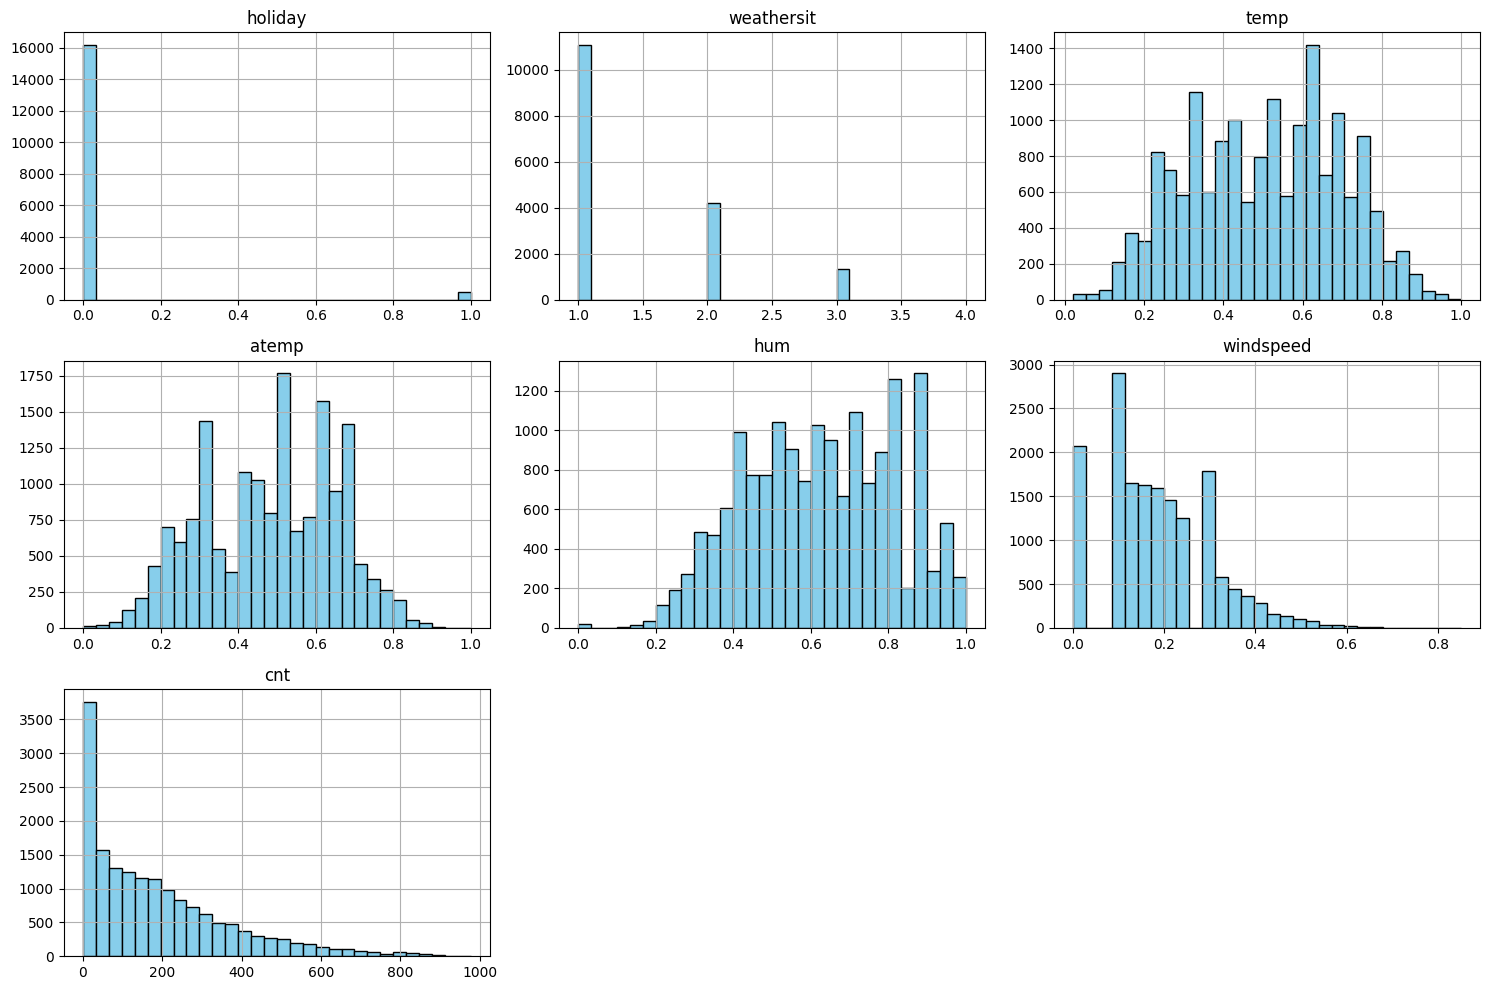


=== Correlatiematrix ===


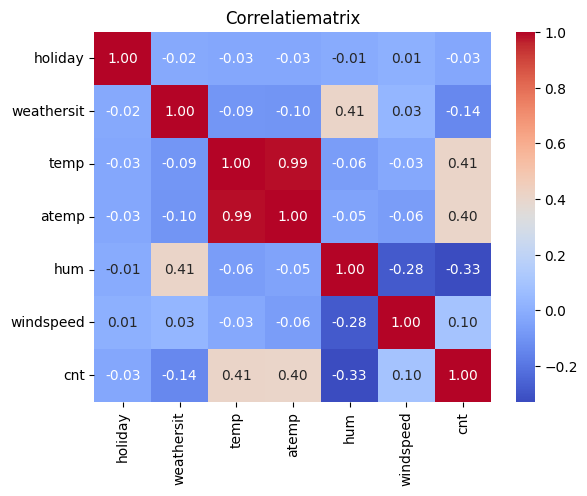

Geen missende waarden gevonden.

=== Boxplots ===


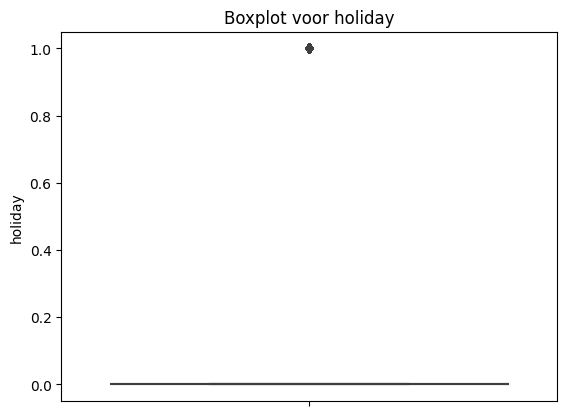

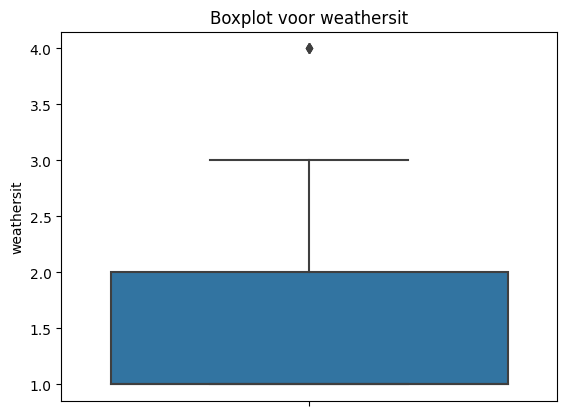

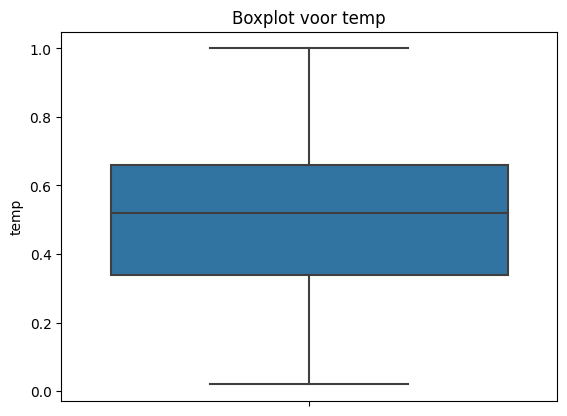

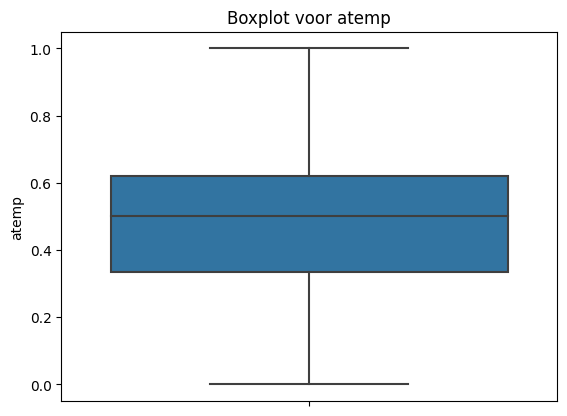

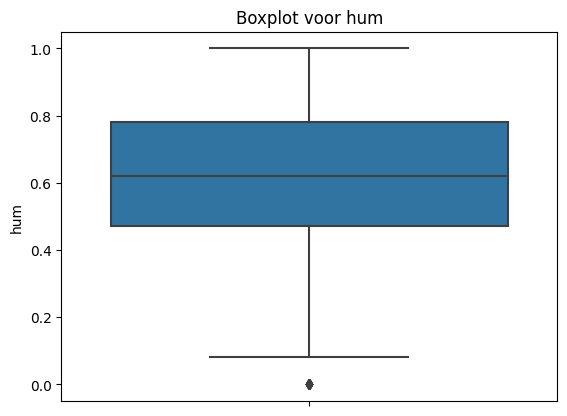

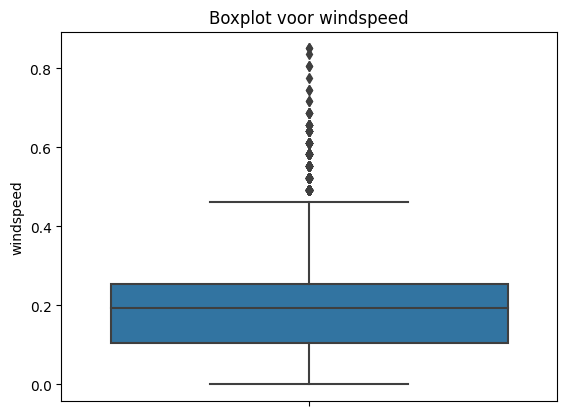

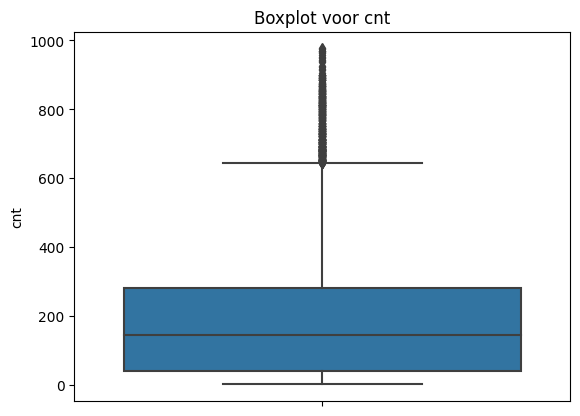

In [ ]:
class EDA:
    def __init__(self, df):
        """
        Initialiseer de EDA-class met een DataFrame.
        
        Parameters:
        df (pd.DataFrame): De dataset voor analyse.
        """
        self.df = df

    def general_info(self):
        """Print algemene informatie over de dataset."""
        print("=== Algemene Informatie ===")
        print(f"Dimensies: {self.df.shape}")
        print(f"Kolommen: {self.df.columns.tolist()}")
        print(f"\nMissende waarden:\n{self.df.isnull().sum()}")
        print(f"\nDtypes:\n{self.df.dtypes}")
        print(f"\nEerste vijf rijen:\n{self.df.head()}")
        
    def summary_statistics(self):
        """Toon beschrijvende statistieken van de dataset."""
        print("\n=== Beschrijvende Statistieken ===")
        print(self.df.describe(include="all"))

    def plot_histograms(self):
        """Visualiseer de verdeling van numerieke kolommen."""
        print("\n=== Histogrammen ===")
        numeric_cols = self.df.select_dtypes(include=[np.number])
        if not numeric_cols.empty:
            numeric_cols.hist(figsize=(15, 10), bins=30, color='skyblue', edgecolor='black')
            plt.tight_layout()
            plt.show()
        else:
            print("Geen numerieke kolommen gevonden.")

    def plot_correlation_matrix(self):
        """Plot een correlatiematrix voor numerieke variabelen."""
        print("\n=== Correlatiematrix ===")
        numeric_cols = self.df.select_dtypes(include=[np.number])
        if numeric_cols.shape[1] > 1:
            corr = numeric_cols.corr()
            sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlatiematrix")
            plt.show()
        else:
            print("Niet genoeg numerieke kolommen voor correlatiematrix.")

    def plot_missing_values(self):
        """Visualiseer missende waarden in de dataset."""
        if self.df.isnull().any().any():
            print("\n=== Missende Waarden Heatmap ===")
            sns.heatmap(self.df.isnull(), cbar=False, cmap='viridis')
            plt.title("Missende Waarden")
            plt.show()
        else:
            print("Geen missende waarden gevonden.")

    def plot_boxplots(self):
        """Plot boxplots om outliers te detecteren."""
        print("\n=== Boxplots ===")
        numeric_cols = self.df.select_dtypes(include=[np.number])
        for col in numeric_cols.columns:
            sns.boxplot(y=self.df[col])
            plt.title(f"Boxplot voor {col}")
            plt.show()

if __name__ == "__main__":




    eda = EDA(train_data)


    eda.general_info()
    eda.summary_statistics()
    eda.plot_histograms()
    eda.plot_correlation_matrix()
    eda.plot_missing_values()
    eda.plot_boxplots()

#https://chatgpt.com/share/674b4caf-de74-8008-95a9-9f3ac338499f